In [1]:
from pathlib import Path
import imageio
import fsspec
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Notes
 * Metadata is a temporary dict of stuff that the Axiom code reads from files. 
 * extrinsic and intrinsic parameters are stored in a list of dicts
 * `metadata['coordinate_system']` indicates whether extrinsics are in local `'xyz'` or world `'geo'` coordinates
 
 * `lcp` is a dict lens calibration parameters, a synonym for intrinsics
 * `beta` is an numpy array that contains the values of the extrinsic dict

In [2]:
# These .py files define the objects that load calibration data and do the rectification
# %run -i coastcam_funcs.py
# %run -i calibration_crs.py
# %run -i chs_rectifier_crs.py
from coastcam_funcs import *
from calibration_crs import *
from rectifier_crs import *

In [3]:
# List of files...three for each camera. Calibration parameters are in .json format
# These are the USGS image filename format
extrinsic_cal_files = ['CACO01_C1_EOBest.json','CACO01_C2_EOBest.json']
intrinsic_cal_files = ['CACO01_C1_IOBest.json','CACO01_C2_IOBest.json']

In [4]:
s3 = False # set to False to test local read, set to True to test bucket read
if s3:
    # read from S3 bucket
    imdir='cmgp-coastcam/cameras/caco-01/products/'
    image_files = ['1600866001.c1.timex.jpg','1600866001.c2.timex.jpg']
    fs = fsspec.filesystem('s3')
else:
    # local test files
    imdir='./'
    image_files = ['1581508801.c1.timex.jpg','1581508801.c2.timex.jpg']
    fs = None

impaths = []
for f in image_files:
    impaths.append(imdir+f)
impaths

['./1581508801.c1.timex.jpg', './1581508801.c2.timex.jpg']

In [5]:
# Dict providing the metadata that the Axiom code infers from the USACE filename format
metadata= {'name': 'CACO-01', 'serial_number': 1, 'camera_number': 'C1', 'calibration_date': '2019-12-12', 'coordinate_system': 'geo'}
# dict providing origin and orientation of the local grid
local_origin = {'x': 410935.,'y':4655890., 'angd': 55.}

In [6]:
# read cal files and make lists of cal dicts
extrinsics_list = []
for f in extrinsic_cal_files:
    extrinsics_list.append( json2dict(f) )
intrinsics_list = []
for f in intrinsic_cal_files:
    intrinsics_list.append( json2dict(f) )

In [7]:
# check test for coordinate system
if metadata['coordinate_system'].lower() == 'xyz':
    print('Extrinsics are local coordinates')
elif metadata['coordinate_system'].lower() == 'geo':
    print('Extrinsics are in world coordinates')
else:
    print('Invalid value of coordinate_system: ',metadata['coordinate_system'])
    
print(extrinsics_list[0])
print(extrinsics_list[0]['y']-local_origin['y'])

Extrinsics are in world coordinates
{'x': 410843.97, 'y': 4655942.49, 'z': 27.3, 'a': -0.271, 't': 1.304, 'r': 0.007}
52.49000000022352


In [8]:
calibration = CameraCalibration(metadata,intrinsics_list[0],extrinsics_list[0],local_origin)
print(calibration.local_origin)
print(calibration.world_extrinsics)
print(calibration.local_extrinsics)

{'x': 410935.0, 'y': 4655890.0, 'angd': 55.0}
{'x': 410843.97, 'y': 4655942.49, 'z': 27.3, 'a': -0.271, 't': 1.304, 'r': 0.007}
{'x': -9.215372196139484, 'y': 104.67443773584442, 'z': 27.3, 'a': 0.6889310885968812, 't': 1.304, 'r': 0.007}


In [9]:
xmin = 0.
xmax = 500.
ymin = 0.
ymax = 700.
dx = 2.
dy = 2.
z =  0.

rectifier_grid = TargetGrid(
    [xmin, xmax],
    [ymin, ymax],
    dx,
    dy,
    z
)
#print(rectifier_grid.X)

rectifier = Rectifier(
    rectifier_grid
)

In [10]:
%%time
#%prun rectified_image = rectifier.rectify_images(metadata, image_files, intrinsics_list, extrinsics_list, local_origin)
rectified_image = rectifier.rectify_images(metadata, impaths, intrinsics_list, extrinsics_list, local_origin, fs=fs)

loop 0 calibrations:
{'NU': 2448, 'NV': 2048, 'c0U': 1150.389769, 'c0V': 1200.529802, 'fx': 3599.302724, 'fy': 3600.840045, 'd1': -0.221394, 'd2': 0.129797, 'd3': 0.0, 't1': 0.000599, 't2': -0.000393} {'x': 410843.97, 'y': 4655942.49, 'z': 27.3, 'a': -0.271, 't': 1.304, 'r': 0.007}
back from CameraCalibration
back from _find_distort_UV
(351, 251)
(2048, 2448, 3) None
back from get_pixels
back from assemble_image_weights
back from apply_weights_to_pixles
loop 1 calibrations:
{'NU': 2448, 'NV': 2048, 'c0U': 1215.323012, 'c0V': 1076.162623, 'fx': 2411.904295, 'fy': 2409.796036, 'd1': -0.219987, 'd2': 0.178703, 'd3': -0.05506, 't1': 0.000114, 't2': -0.002621} {'x': 410844.14, 'y': 4655942.41, 'z': 27.3, 'a': 0.5, 't': 1.173, 'r': 0.03}
back from CameraCalibration
back from _find_distort_UV
(351, 251)
(2048, 2448, 3) None
back from get_pixels
back from assemble_image_weights
back from apply_weights_to_pixles
CPU times: user 812 ms, sys: 1.02 s, total: 1.83 s
Wall time: 636 ms


In [11]:
# This complains about a lossy conversion to uint8. Python does not have the ability to store NaNs in an integer array.
# Should we make NaNs zeros?
# What is the final product we want? An image, a geotiff, or netCDF/HDF file w/ metadata?
# The flip command is needed because the array is not in image order.

# write a local file
ofile = 'caco01_test_product.png'
imageio.imwrite(ofile,np.flip(rectified_image,0),format='png')

Lossy conversion from float64 to uint8. Range [4.141949613382125, 255.00000000000006]. Convert image to uint8 prior to saving to suppress this warning.


In [12]:
# write to the public sfm bucket
fs2 = fsspec.filesystem('s3', profile='default')
with fs2.open('s3://cmgp-sfm-public-read-bucket/csherwood/'+ofile,'wb') as fo:
    imageio.imwrite(fo,np.flip(rectified_image,0),format='png')

Lossy conversion from float64 to uint8. Range [4.141949613382125, 255.00000000000006]. Convert image to uint8 prior to saving to suppress this warning.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


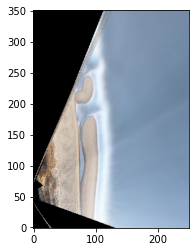

In [13]:
plt.imshow( rectified_image.astype(np.int))
plt.gca().invert_yaxis()

In [14]:
print(np.shape(rectified_image))

(351, 251, 3)


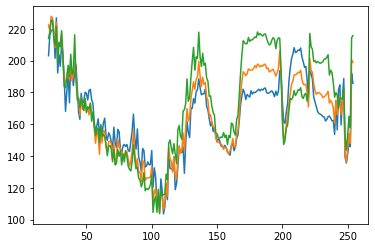

In [15]:
plt.plot(rectified_image[:,75,:])